## 1. Loading and displaying data, baseline model

### 1.1 Loading data

In [1]:
import pandas as pd

train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,pixel1024
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,157,157,157,157,157,158,158,...,149,163,175,175,175,175,175,149,149,149
2,2,187,188,188,188,188,188,188,188,188,...,202,201,200,199,199,199,198,195,195,195
3,2,211,211,212,212,212,212,212,212,211,...,235,234,233,231,230,229,229,229,229,163
4,13,164,167,170,172,176,179,180,184,185,...,133,163,163,163,164,179,179,179,179,179


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(ax, pixels, title="Image Display", xlabel="Width", ylabel="Height"):
    # Reshape the pixel data to a 2D array (32x32, as you have 1024 pixels)
    image_array = np.array(pixels).reshape(32, 32)
    # Display the image on the given axes
    im = ax.imshow(image_array, cmap='gray')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

### 1.2 Display the sample of data

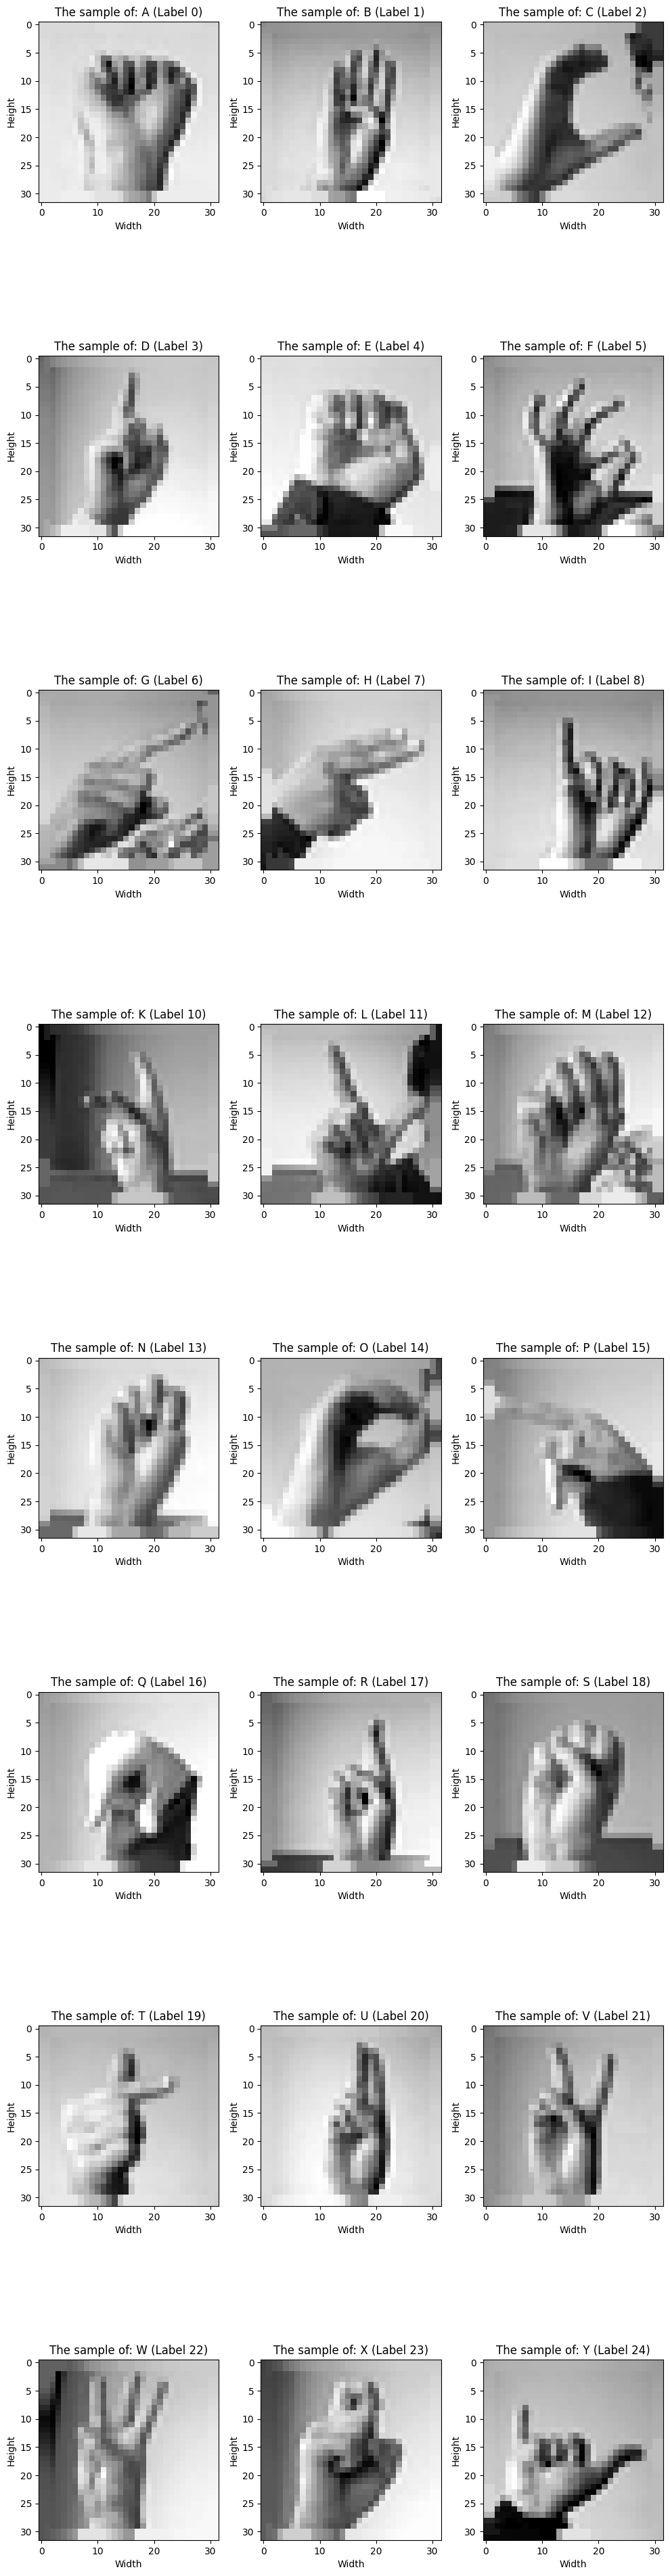

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

sample_names = sorted(train_data["label"].unique())
n_samples = len(sample_names)
n_cols = 3
n_rows = (n_samples + 1) // n_cols  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5))  # Adjust size as needed
axes = axes.flatten()  # Flatten the array to simplify the iteration

encoder = LabelEncoder()
encoder.fit([chr(i) for i in range(ord('A'), ord('Z')+1)])

for index, i in enumerate(sample_names):
    filtered_df = train_data[train_data["label"] == i]
    pixels = filtered_df.loc[:, "pixel1":].values[0]
    title = f"The sample of: {encoder.inverse_transform([i])[0]} (Label {i})"
    plot_image(axes[index], pixels, title)


# Handle any leftover axes if there are any
for ax in axes[index + 1:]:
    ax.set_visible(False)

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()


### 1.3 Data spliting and data preprocessing 

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train_data = train_data.drop('label', axis=1)
y_train_data = train_data['label']

X_val_test_data = test_data.drop('label', axis=1)
y_val_test_data = test_data['label']

label_to_num = {label: idx for idx, label in enumerate(np.unique(y_train_data))}
num_to_label = {v:k for k,v in label_to_num.items()}

y_train = y_train_data.apply(lambda x: label_to_num[x])
y_val_test = y_val_test_data.apply(lambda x: label_to_num[x])

X_test_data, X_val_data, y_test, y_val = train_test_split(X_val_test_data, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

X_train_raw = X_train_data.values.reshape(-1, 32, 32, 1)
X_val_raw = X_val_data.values.reshape(-1, 32, 32, 1)
X_test_raw = X_test_data.values.reshape(-1, 32, 32, 1)

generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
X_train_flow = generator.flow(X_train_raw, y_train, batch_size=32)
X_val_flow = generator.flow(X_val_raw, y_val, batch_size=32)

X_val = X_val_raw/ 255.0
X_test = X_test_raw/ 255.0

In [5]:
def plot_sample(y_data, data_name):
    y_data = pd.Series(y_data).apply(lambda x: num_to_label[x])
    class_counts = y_data.value_counts()
    
    all_labels = pd.Index(range(25))  # This creates an index from 0 to 24
    class_counts = class_counts.reindex(all_labels, fill_value=0)  # Reindexing and filling missing values with 0
    
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar')
    plt.title(f'Class Distribution in {data_name}')
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)  # Rotate labels to horizontal for readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


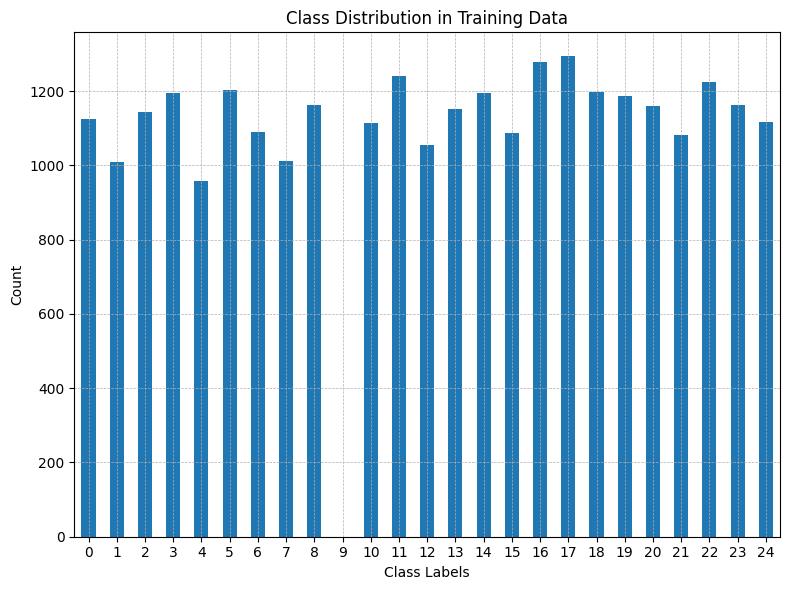

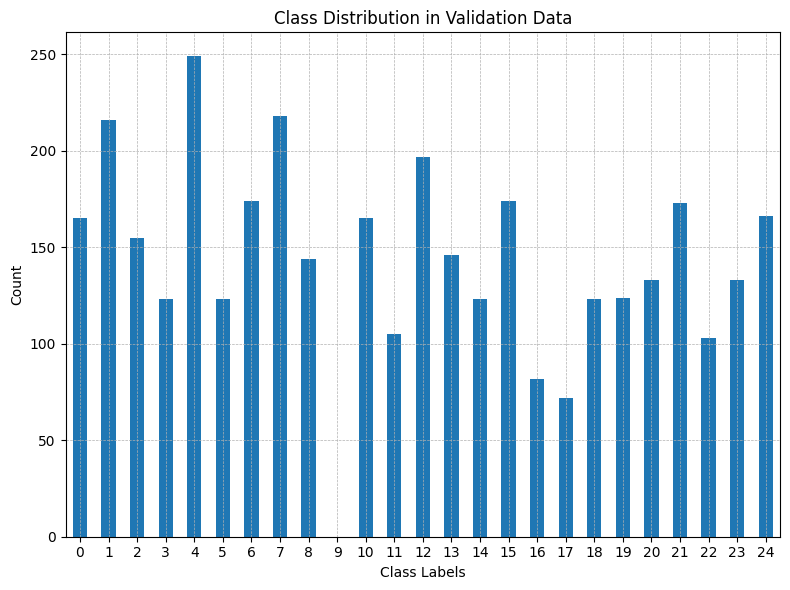

In [6]:
plot_sample(y_train, 'Training Data')
plot_sample(y_val, 'Validation Data')

#### 1.4 The baseline Dense Model

In [7]:
from tensorflow import keras

def model_dense(model_config):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [32, 32, 1]))    # always have same sized inputs
    for n in  model_config["hidden_sizes"]:
        model.add(keras.layers.Dense(n, activation = model_config["activation_function"]))
    model.add(keras.layers.Dense(24, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=model_config["optimizer"](learning_rate=model_config["learning_rate"]), metrics=["accuracy"])
    return model

In [8]:
baseline_model_config = {
    'hidden_sizes': [32, 32, 256],  
    'activation_function': "relu",
    'optimizer': keras.optimizers.legacy.Adam,              
    'learning_rate': 0.001
}

dense_baseline_model = model_dense(baseline_model_config)

In [9]:
dense_baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 32)                32800     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dense_3 (Dense)             (None, 24)                6168      
                                                                 
Total params: 48472 (189.34 KB)
Trainable params: 48472 (189.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
def train_model(model, n_epochs=50, verbose=1):
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)]
    
    history = model.fit(X_train_flow, epochs=n_epochs,
                        callbacks=callbacks, validation_data=X_val_flow, verbose=verbose)

    max_val_acc = np.max(history.history['val_accuracy'])
    return max_val_acc, history, model

def plot_learning_curves(history, title):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.title(f'{title} Learning Curve')
    plt.xlabel('Epochs')
    plt.grid(True)  
    plt.legend(loc='best') 
    plt.show()

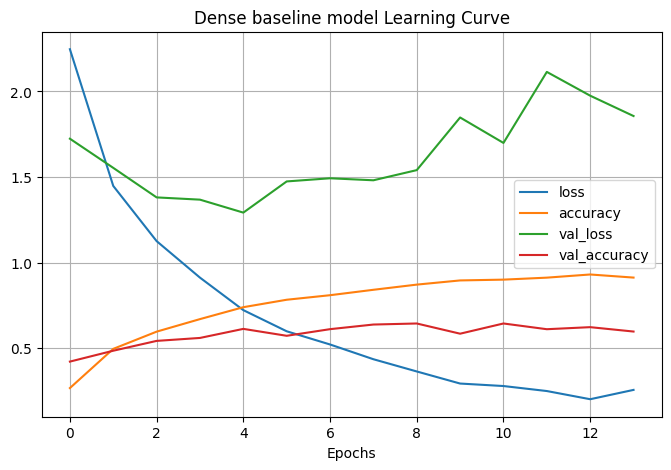

In [11]:
dense_baseline_max_val_acc, dense_baseline_history, dense_baseline_model = train_model(dense_baseline_model, n_epochs=20, verbose=0)
plot_learning_curves(dense_baseline_history, "Dense baseline model")

In [ ]:
def calculate_letter_accuracies(model, X_data, y_data):
    y_pred_num = model.predict(X_data, verbose=0)
    y_pred_num = np.argmax(y_pred_num, axis=1)

    y_pred = np.array([num_to_label[i] for i in y_pred_num])
    y_true = y_data.apply(lambda x: num_to_label[x])

    accuracies = {}
    overall_accuracy_metric = keras.metrics.Accuracy()

    overall_accuracy_metric.update_state(y_pred, y_true)
    overall_accuracy = overall_accuracy_metric.result().numpy()

    unique_classes = np.unique(y_true)
    for class_id in unique_classes:
        acc_metric = keras.metrics.Accuracy()

        mask = (y_true == class_id)
        acc_metric.update_state(y_pred[mask], y_true[mask])

        accuracies[class_id] = acc_metric.result().numpy()

    mean_accuracy = np.mean(list(accuracies.values()))
    median_accuracy = np.median(list(accuracies.values()))

    sorted_accuracies = sorted(accuracies.items(), key=lambda item: item[1])
    highest_accuracy_letter = {sorted_accuracies[-1][0]: sorted_accuracies[-1][1]}
    lowest_accuracy_letter = {sorted_accuracies[0][0]: sorted_accuracies[0][1]}
    top_3_error = dict(sorted_accuracies[:3])

    result = {
        "Mean Accuracy": mean_accuracy,
        "Median Accuracy": median_accuracy,
        "Highest Accuracy Letter": highest_accuracy_letter,
        "Lowest Accuracy Letter": lowest_accuracy_letter,
        "Top 3 Error": top_3_error,
        "Individual Accuracies": accuracies
    }

    return result

def interpret_result(result):
    print("Mean Accuracy: {:.2f}".format(result["Mean Accuracy"]))
    print("Median Accuracy: {:.2f}".format(result["Median Accuracy"]))
    
    highest_accuracy_letter = list(result["Highest Accuracy Letter"].items())[0]
    lowest_accuracy_letter = list(result["Lowest Accuracy Letter"].items())[0]

    print(f"\nHighest Accuracy Letter: {encoder.inverse_transform([highest_accuracy_letter[0]])[0]} with {highest_accuracy_letter[1]:.2f} accuracy")
    print(f"Lowest Accuracy Letter: {encoder.inverse_transform([lowest_accuracy_letter[0]])[0]} with {lowest_accuracy_letter[1]:.2f} accuracy")

    print("\nTop 3 Labels with Lowest Accuracies:")
    for label, accuracy in result["Top 3 Error"].items():
        print(f"Accuracy for letter {encoder.inverse_transform([label])[0]}: {accuracy:.2f}")

    print("\nIndividual Accuracies:")
    for label, accuracy in result["Individual Accuracies"].items():
        print(f"Accuracy for letter {encoder.inverse_transform([label])[0]}: {accuracy:.2f}")

In [13]:
baseline_result = calculate_letter_accuracies(dense_baseline_model, X_val, y_val)

interpret_result(baseline_result)

Mean Accuracy: 0.61
Median Accuracy: 0.63

Highest Accuracy Letter: A with 0.95 accuracy
Lowest Accuracy Letter: R with 0.07 accuracy

Top 3 Labels with Lowest Accuracies:
Accuracy for letter R: 0.07
Accuracy for letter N: 0.23
Accuracy for letter K: 0.25

Individual Accuracies:
Accuracy for letter A: 0.95
Accuracy for letter B: 0.90
Accuracy for letter C: 0.92
Accuracy for letter D: 0.39
Accuracy for letter E: 0.87
Accuracy for letter F: 0.70
Accuracy for letter G: 0.64
Accuracy for letter H: 0.82
Accuracy for letter I: 0.59
Accuracy for letter K: 0.25
Accuracy for letter L: 0.65
Accuracy for letter M: 0.57
Accuracy for letter N: 0.23
Accuracy for letter O: 0.59
Accuracy for letter P: 0.78
Accuracy for letter Q: 0.48
Accuracy for letter R: 0.07
Accuracy for letter S: 0.43
Accuracy for letter T: 0.45
Accuracy for letter U: 0.70
Accuracy for letter V: 0.61
Accuracy for letter W: 0.73
Accuracy for letter X: 0.74
Accuracy for letter Y: 0.60


#### 1.5 Summary of Baseline model performance:

| Metric                                   | dense_baseline_model |
|------------------------------------------|----------------------|
| **Total Parameters**                     |48,472 |
| **Mean Accuracy**                        | 0.61                 |
| **Median Accuracy**                      | 0.63                 |
| **Highest Accuracy Letter**              | A (0.95)             |
| **Lowest Accuracy Letter**               | R (0.07)             |
| **Top 3 Labels with Lowest Accuracies**  |                      |
|                                         | R(0.07)                 |
|                                         | N(0.23)                 |
|                                         | K(0.25)                |
| **Individual Accuracies**                |                      |
| Accuracy for letter A                    | 0.95                 |
| Accuracy for letter B                    | 0.90                 |
| Accuracy for letter C                    | 0.92                 |
| Accuracy for letter D                    | 0.39                 |
| Accuracy for letter E                    | 0.87                 |
| Accuracy for letter F                    | 0.70                 |
| Accuracy for letter G                    | 0.64                 |
| Accuracy for letter H                    | 0.82                 |
| Accuracy for letter I                    | 0.59                 |
| Accuracy for letter K                    | 0.25                 |
| Accuracy for letter L                    | 0.65                 |
| Accuracy for letter M                    | 0.57                 |
| Accuracy for letter N                    | 0.23                 |
| Accuracy for letter O                    | 0.59                 |
| Accuracy for letter P                    | 0.78                 |
| Accuracy for letter Q                    | 0.48                 |
| Accuracy for letter R                    | 0.07                 |
| Accuracy for letter S                    | 0.43                 |
| Accuracy for letter T                    | 0.45                 |
| Accuracy for letter U                    | 0.70                 |
| Accuracy for letter V                    | 0.61                 |
| Accuracy for letter W                    | 0.73                 |
| Accuracy for letter X                    | 0.74                 |
| Accuracy for letter Y                    | 0.60                 |


## 2. Model Optimisation

In [26]:
dense_lr_results, dense_layers_results, dense_optimizer_results, dense_activation_function_result = {}, {}, {}, {}

cnn_lr_results, cnn_layers_results, cnn_optimizer_results, cnn_activation_function_result = {}, {}, {}, {}

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_results(lr_results, parameter, type='line'):
    # Initialize a list to hold each row of the DataFrame
    rows = []
    
    # Iterate through each key in the dictionary (each learning rate)
    for lr, data in lr_results.items():
        # Access the 'result' dictionary for this learning rate
        result = data['result']
        
        row = {
            parameter: lr,
            'Total Parameter': data['total_parameters'],
            'Median Accuracy': result['Median Accuracy'],
            'Highest Accuracy Letter: Accuracy': f"{list(result['Highest Accuracy Letter'].items())[0][0]} : {list(result['Highest Accuracy Letter'].items())[0][1]:.2f}",
            'Lowest Accuracy Letter: Accuracy': f"{list(result['Lowest Accuracy Letter'].items())[0][0]} : {list(result['Lowest Accuracy Letter'].items())[0][1]:.2f}",
            'Top 3 Errors': {k: round(v, 2) for k, v in sorted(result['Individual Accuracies'].items(), key=lambda x: x[1])[:3]}
        }
        
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df.set_index(parameter, inplace=True)
    df = df[['Total Parameter', 'Median Accuracy', 'Highest Accuracy Letter: Accuracy', 
             'Lowest Accuracy Letter: Accuracy', 'Top 3 Errors']]

    display(df)

    # Plotting results
    n_lrs = len(lr_results)
    n_cols = 2  # We want two columns
    total_plots = n_lrs + 1
    n_rows = (total_plots + 1) // n_cols if total_plots % n_cols else total_plots // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 5 * n_rows), constrained_layout=True)

    accuracies = []
    learning_rates = []

    subplot_idx = 0
    for lr, results in sorted(lr_results.items()):
        row = subplot_idx // n_cols
        col = subplot_idx % n_cols
        history_df = pd.DataFrame(results['history'].history)
        history_df.plot(ax=axes[row, col])
        axes[row, col].set_title(f'Learning Curve for {parameter}={lr}')
        axes[row, col].set_xlabel('Epochs')
        axes[row, col].set_ylabel('Metric')
        axes[row, col].grid(True)
        subplot_idx += 1
        accuracies.append(results['accuracy'])
        learning_rates.append(lr)

    # Decide plot type for the final plot based on the 'type' parameter
    row = subplot_idx // n_cols
    col = subplot_idx % n_cols
    if type == 'line':
        axes[row, col].plot(learning_rates, accuracies, marker='o', linestyle='-')
    elif type == 'bar':
        axes[row, col].bar(learning_rates, accuracies, color='skyblue')
    axes[row, col].set_title(f'Accuracy by {parameter}')
    axes[row, col].set_xlabel(f'{parameter}')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].grid(True)
    
    # Hide any unused subplot if the total number of plots is odd
    if total_plots % n_cols:
        fig.delaxes(axes[row, col + 1])

    plt.show()


### 2.1 The Hyper-parameter optimisation for Dense model:

#### The optimal learning rate for Dense model:
- `0.001` is the optimal learning rate for Dense model
- The best performance in `Median Accuracy` with `0.73`
- The best performance in `Highest Accuracy Letter` and `Lowest Accuracy Letter` with `1.00` and `0.44`
- The best performance in `Maxium validation accuracy` with over `0.7`

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
Dense Learning Rate,,,,,
1.0000,48472,0.000000,4 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
0.1000,48472,0.000000,15 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
0.0100,48472,0.000000,19 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
0.0010,48472,0.734898,16 : 1.00,19 : 0.44,"{19: 0.44, 20: 0.5, 18: 0.54}"
0.0001,48472,0.730244,0 : 0.95,10 : 0.16,"{10: 0.16, 12: 0.29, 19: 0.36}"


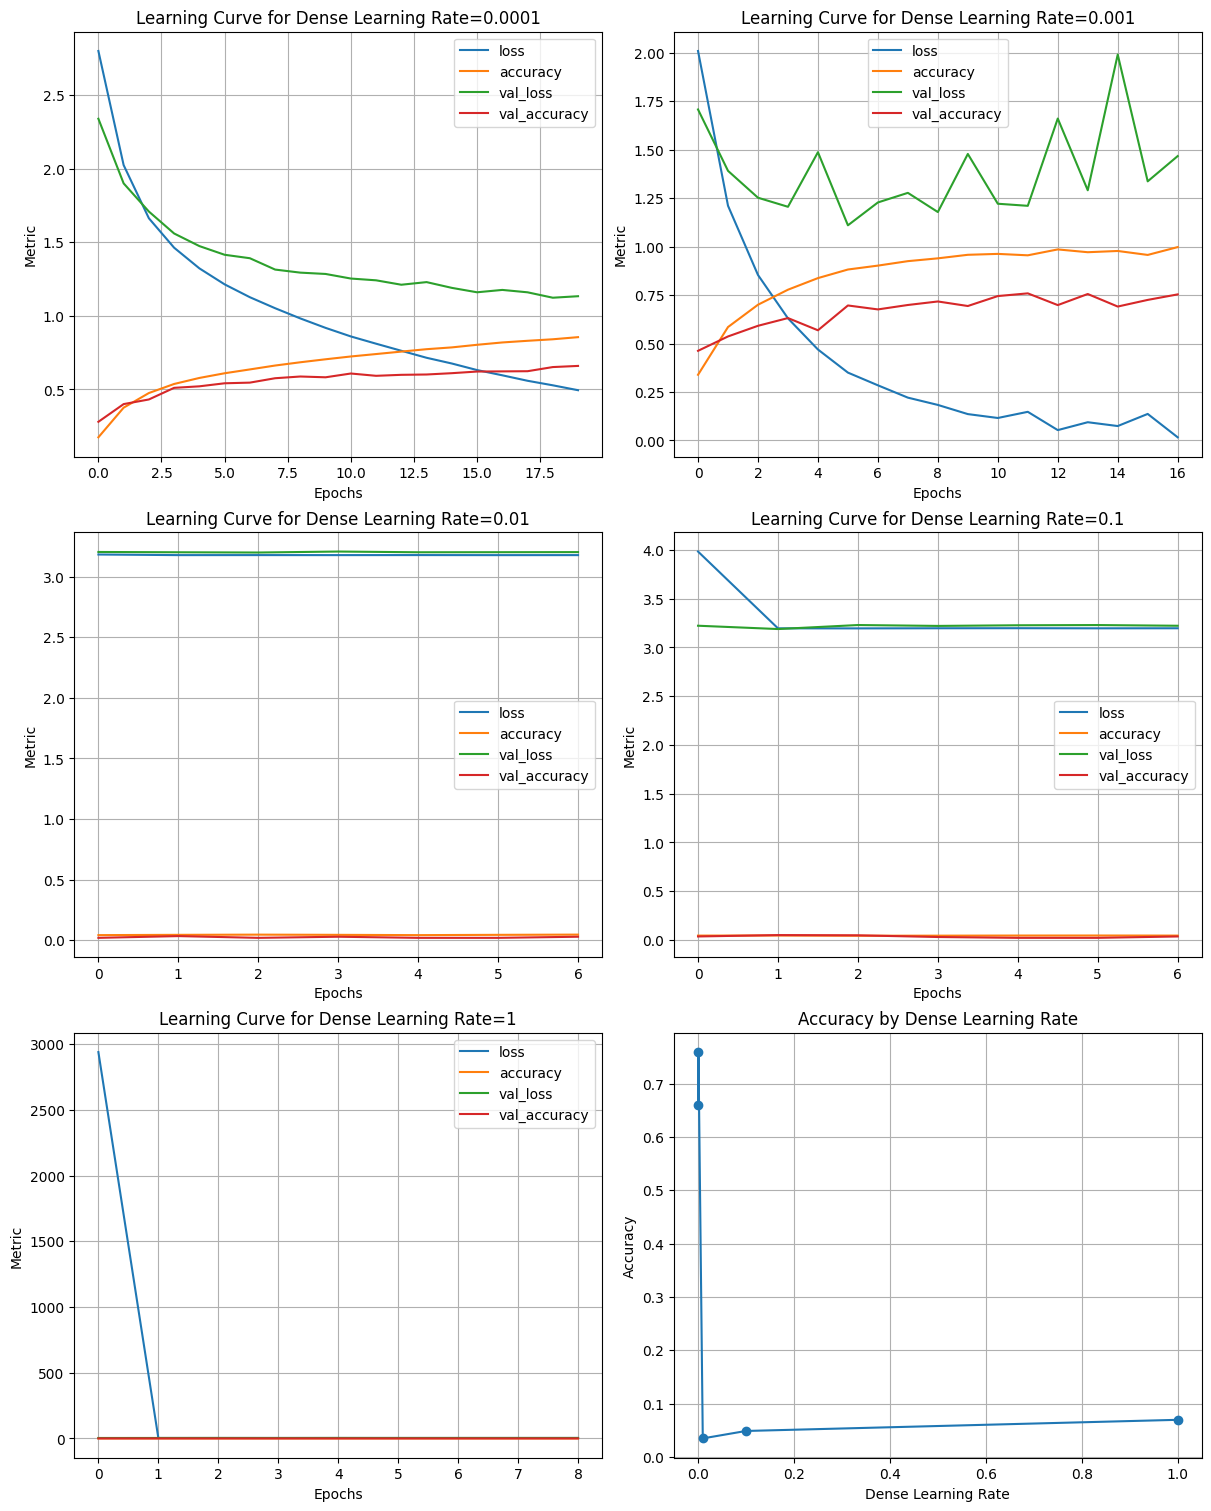

In [204]:
lr_setup = [1,0.1, 0.01,0.001,0.0001]

for i in lr_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = i
    model = model_dense(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20,verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    dense_lr_results[i] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}  

plot_results(dense_lr_results, "Dense Learning Rate")

#### The optimal number of layers for Dense model:
- `128` is the optimal number of layers for Dense model
- The best performance in `Median Accuracy` with `0.75`
- The best performance in `Highest Accuracy Letter` and `Lowest Accuracy Letter` with `1.00` and `0.42`
- The best performance in `Maxium validation accuracy` with over `0.7`
- The number of total parameter is `76,216`, which fits the requirement of being under `500,000`.

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
Dense Number of Layers,,,,,
16,43848,0.550248,16 : 0.85,13 : 0.15,"{13: 0.15, 21: 0.22, 22: 0.24}"
32,48472,0.529266,4 : 0.90,22 : 0.12,"{22: 0.12, 13: 0.14, 21: 0.18}"
64,57720,0.306339,2 : 0.81,18 : 0.05,"{18: 0.05, 24: 0.06, 19: 0.09}"
128,76216,0.754934,16 : 1.00,12 : 0.42,"{12: 0.42, 13: 0.45, 18: 0.46}"
256,113208,0.232197,2 : 0.66,4 : 0.00,"{4: 0.0, 7: 0.0, 8: 0.0}"


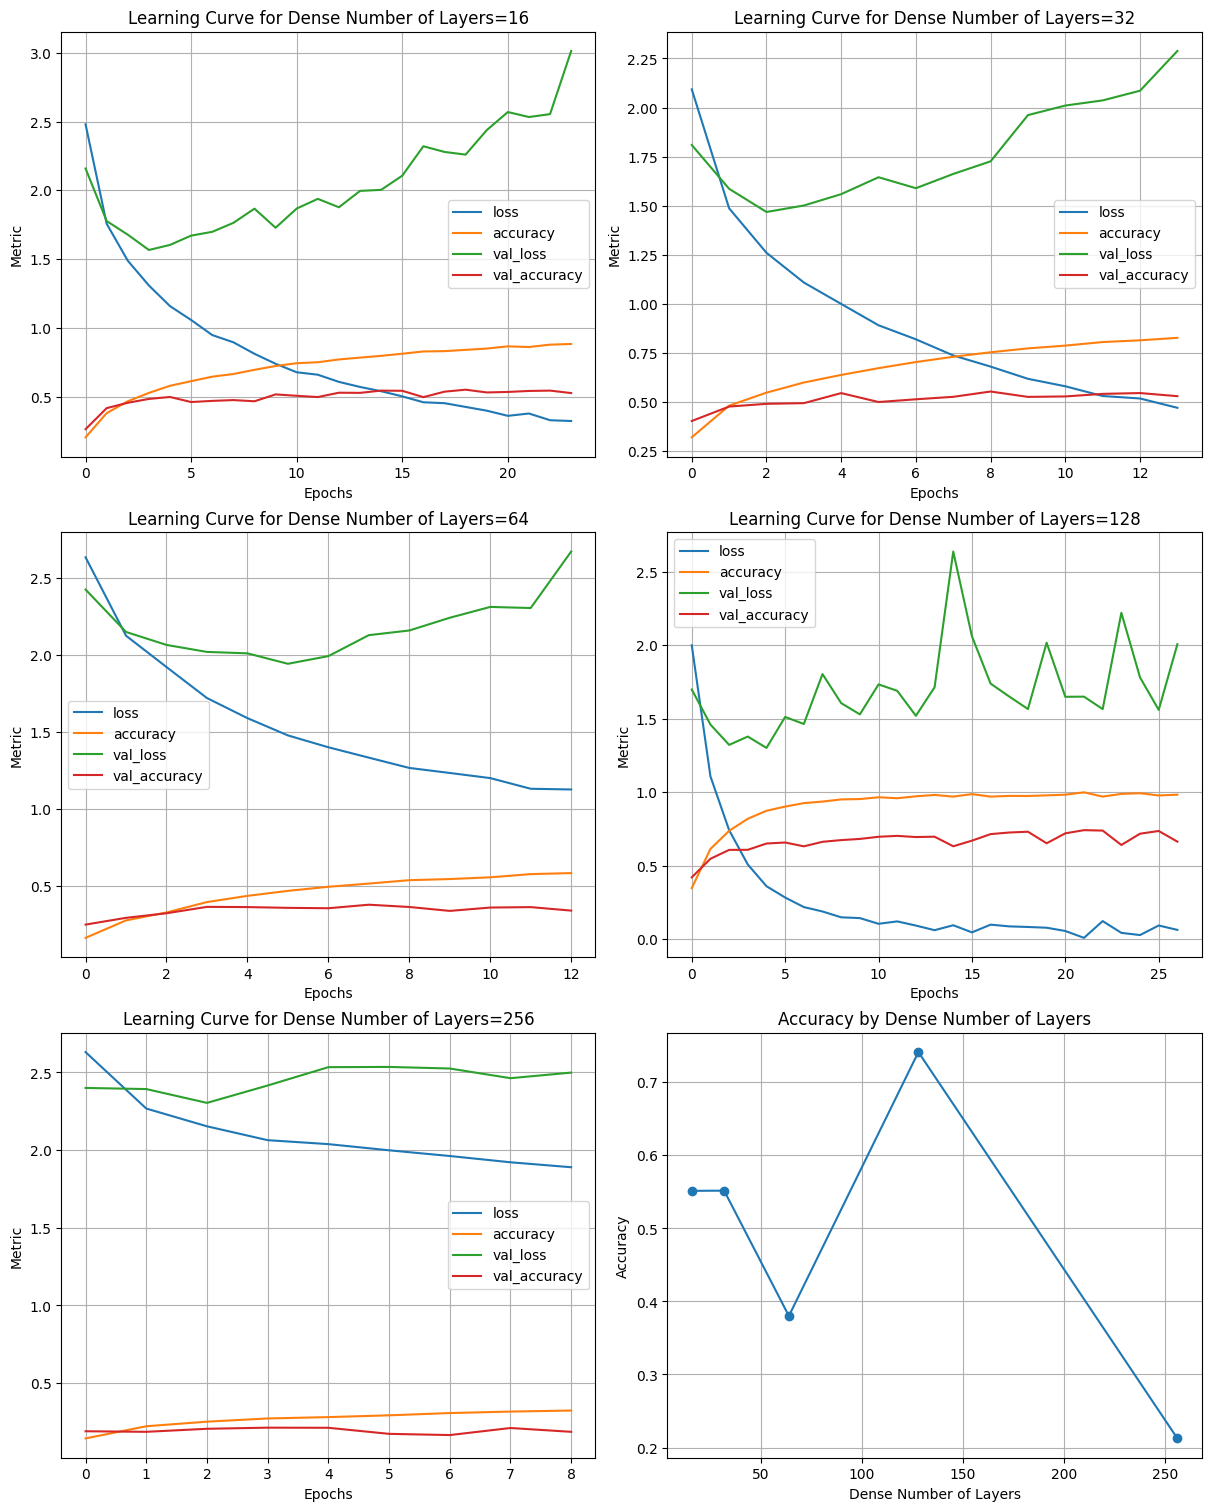

In [205]:
layers_setup = [16, 32, 64, 128, 256]

for i in layers_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32,i,256]
    model = model_dense(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=50, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    dense_layers_results[i] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(dense_layers_results, "Dense Number of Layers")

#### The best optimizer for Dense model:
- `Nadam` is the best optimizer for Dense model
- The best performance in `Median Accuracy` with `0.78`
- The best performance in `Highest Accuracy Letter` and `Lowest Accuracy Letter` with `1.00` and `0.45`
- The best performance in `Maxium validation accuracy` with over `0.7`

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
Dense Optimizer,,,,,
SGD,76216,0.385218,11 : 1.00,21 : 0.08,"{21: 0.08, 12: 0.1, 18: 0.11}"
Adam,76216,0.195679,2 : 0.71,3 : 0.00,"{3: 0.0, 7: 0.0, 17: 0.0}"
RMSprop,76216,0.731593,2 : 1.00,10 : 0.28,"{10: 0.28, 13: 0.43, 21: 0.43}"
Nadam,76216,0.782028,2 : 1.00,10 : 0.45,"{10: 0.45, 19: 0.5, 18: 0.5}"
Adadelta,76216,0.008934,2 : 0.89,5 : 0.00,"{1: 0.0, 5: 0.0, 6: 0.0}"


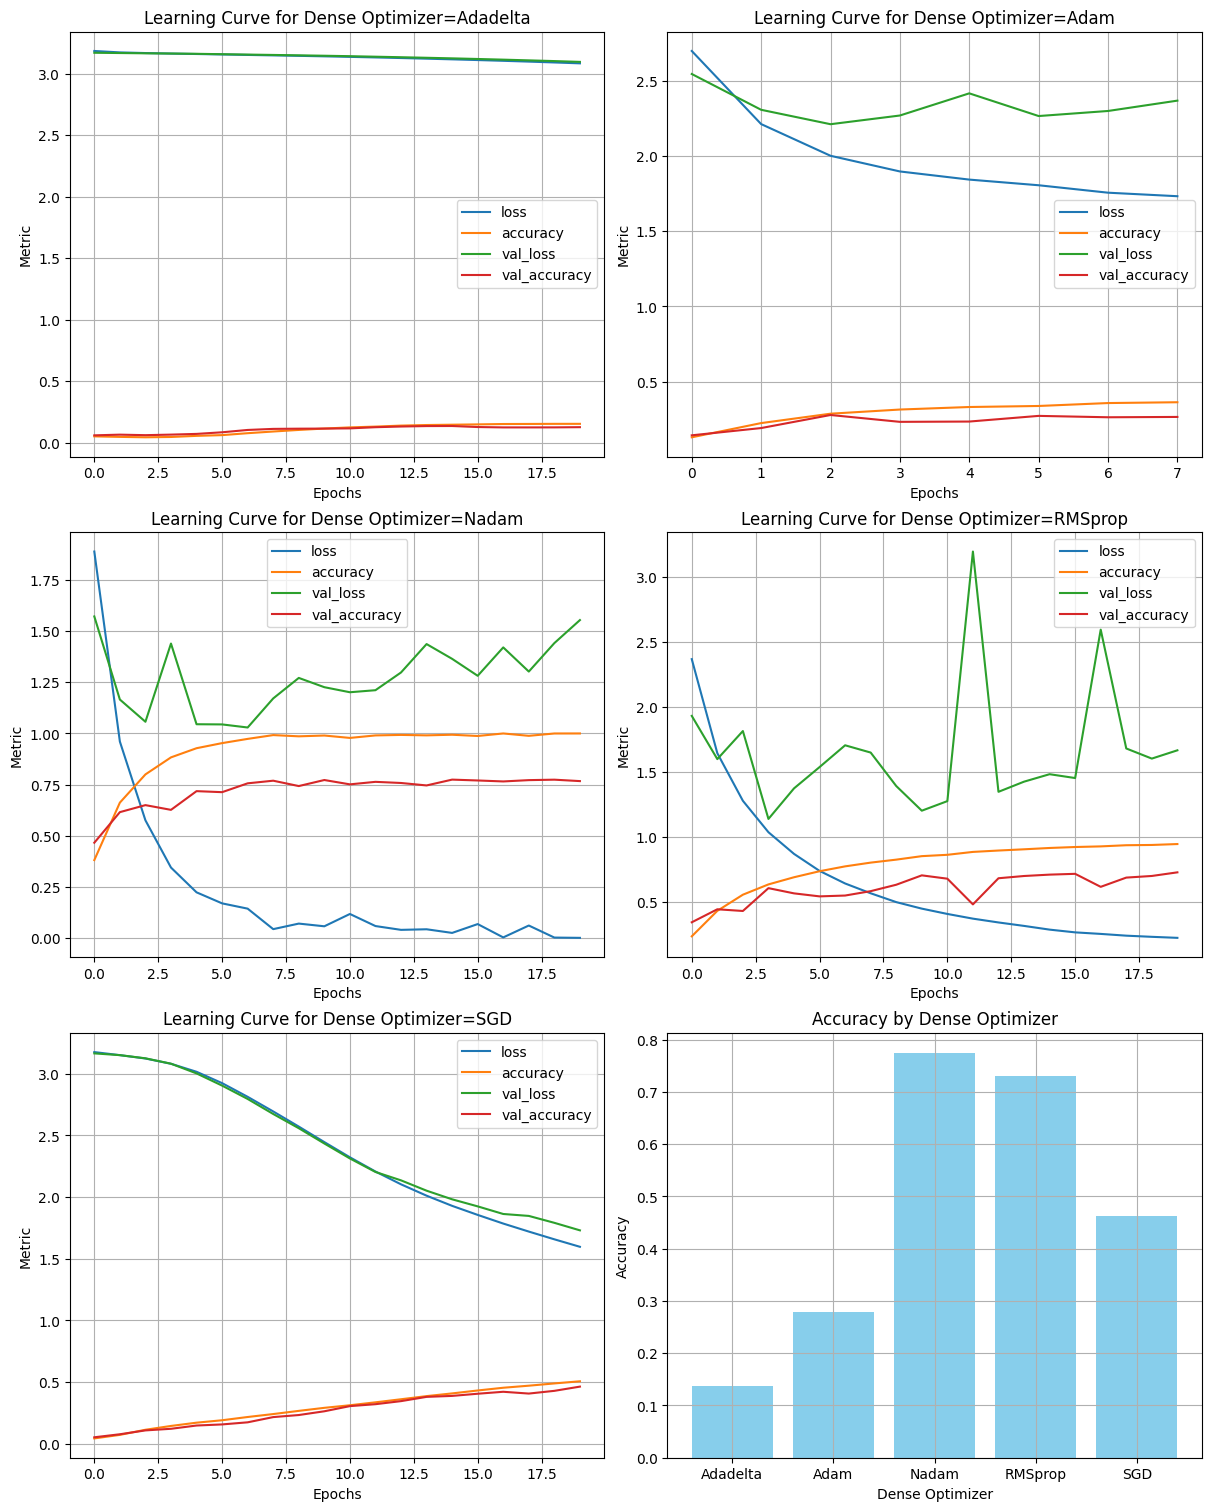

In [206]:
optimizer_setup = [keras.optimizers.legacy.SGD, keras.optimizers.legacy.Adam,keras.optimizers.legacy.RMSprop, keras.optimizers.legacy.Nadam, keras.optimizers.legacy.Adadelta]

for i in optimizer_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32,128,256]
    model_config_copy['optimizer'] = i
    model = model_dense(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    dense_optimizer_results[i.__name__] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(dense_optimizer_results, "Dense Optimizer", type='bar')

#### The optimal activation function for the Dense model:
- `elu` is the optimal activation function for the Dense model.
- It achieves the best performance in `Median Accuracy` with a value of `0.84`.
- Although it does not have the best performance in the `Lowest Accuracy Letter`, it provides a balanced `Median Accuracy`, making it the best overall choice.
- It also achieves the best performance in `Maximum Validation Accuracy` with a value over `0.8`.


,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
Dense activation function,,,,,
relu,76216,0.560266,4 : 0.96,13 : 0.12,"{13: 0.12, 24: 0.19, 17: 0.24}"
elu,76216,0.841459,16 : 1.00,18 : 0.46,"{18: 0.46, 22: 0.55, 10: 0.56}"
leaky_relu,76216,0.789237,16 : 1.00,18 : 0.53,"{18: 0.53, 13: 0.63, 19: 0.65}"
selu,76216,0.775792,11 : 1.00,24 : 0.64,"{24: 0.64, 13: 0.64, 18: 0.65}"
tanh,76216,0.797141,0 : 1.00,13 : 0.48,"{13: 0.48, 18: 0.57, 19: 0.57}"


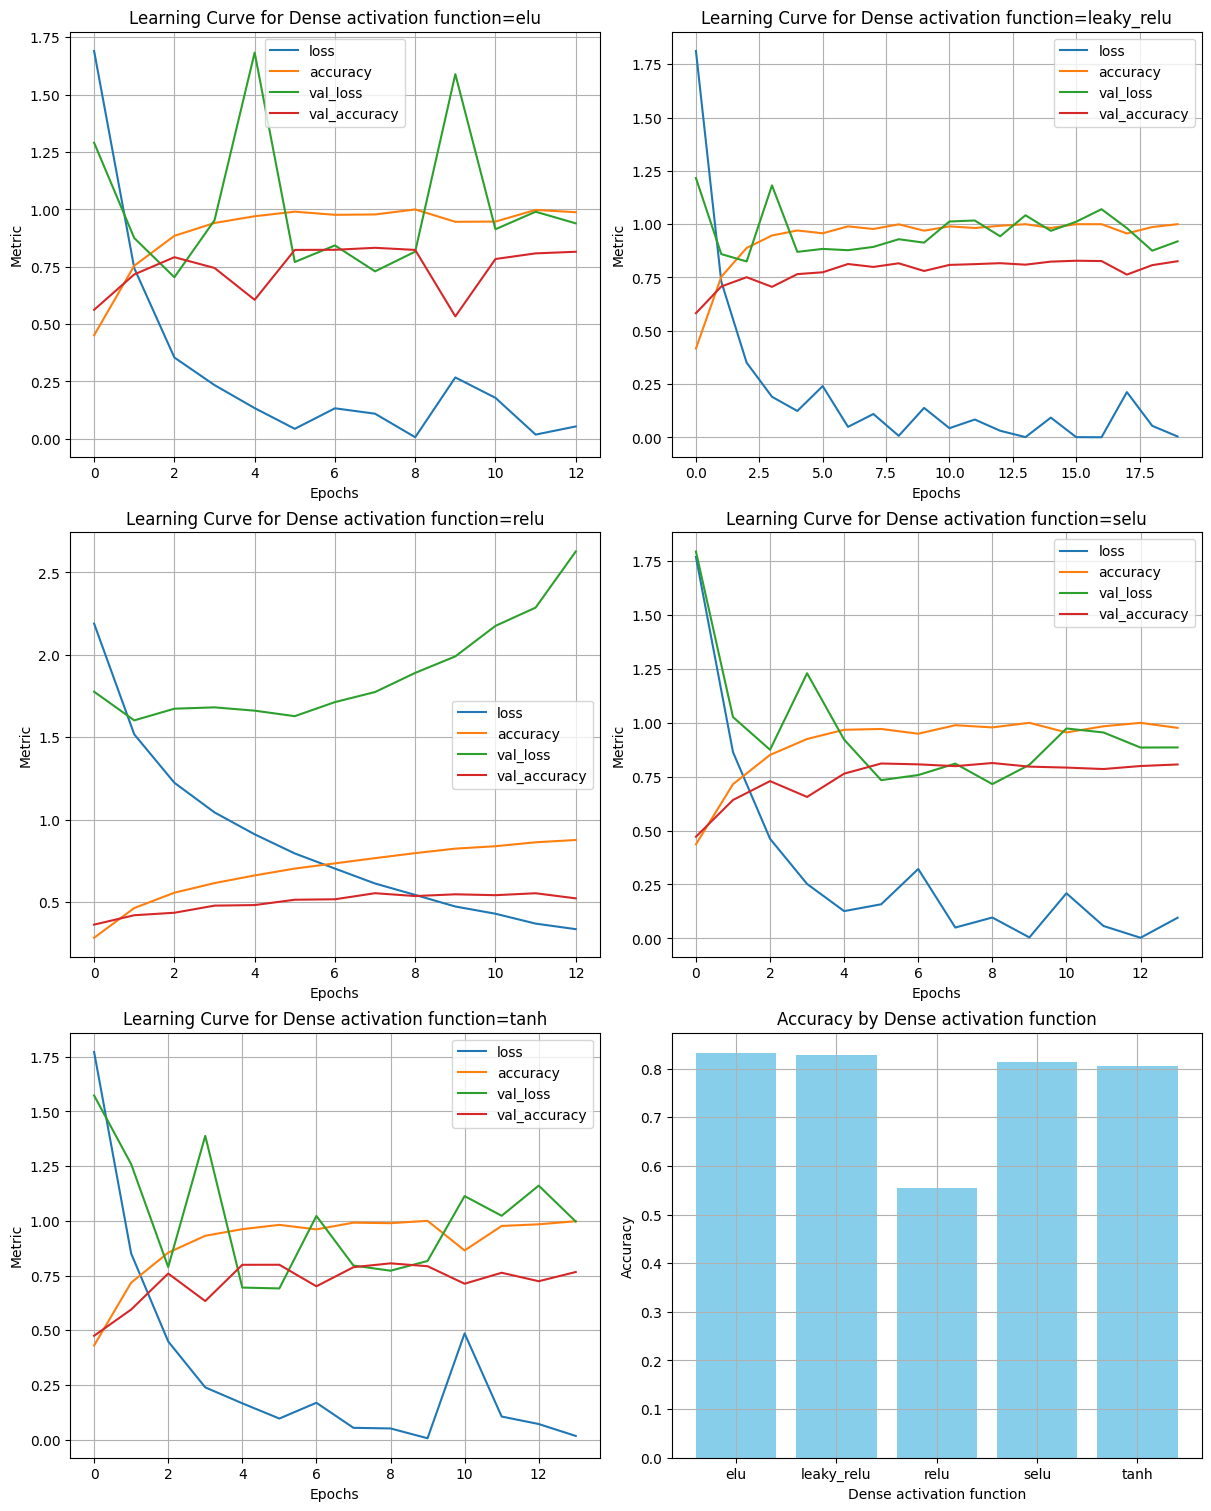

In [208]:
activation_function_setup = ["relu", "elu", "leaky_relu", "selu", "tanh"]

for i in activation_function_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32,128,256]
    model_config_copy['optimizer'] = keras.optimizers.legacy.Nadam
    model_config_copy['activation_function'] = i
    model = model_dense(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    dense_activation_function_result[i] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(dense_activation_function_result, "Dense activation function", type='bar')

#### The summary of the optimal Hyper-parameter for Dense model:
| Parameter               | Value                                 |
|-------------------------|---------------------------------------|
| **Hidden Sizes**         | [32, 128, 256]  |
| **Activation Function**  | `elu`                                |
| **Optimizer**            | `keras.optimizers.legacy.Nadam`       |
| **Learning Rate**        | 0.001                                 |


### 2.2 The Hyper-parameter optimisation for CNN model:

In [14]:
def model_cnn(model_config):
    model = keras.models.Sequential()

    # Input and first convolutional layer
    model.add(keras.layers.Conv2D(filters=model_config["hidden_sizes"][0], kernel_size=(3,3), 
                     activation=model_config["activation_function"], input_shape=(32,32,1)))
    
    model.add(keras.layers.MaxPooling2D(pool_size=2, padding='same'))
    
    # Second convolutional layer
    model.add(keras.layers.Conv2D(filters=model_config["hidden_sizes"][1], kernel_size=(3,3), activation=model_config["activation_function"]))
    model.add(keras.layers.MaxPooling2D(pool_size=2, padding='same'))
    
    # Third convolutional layer
    model.add(keras.layers.Conv2D(filters=model_config["hidden_sizes"][2], kernel_size=(3,3), activation=model_config["activation_function"]))
    model.add(keras.layers.MaxPooling2D(pool_size=2, padding='same'))
    
    # Flatten the output for the dense layers
    model.add(keras.layers.Flatten())
    
    # Dense layers
    model.add(keras.layers.Dense(128, activation=model_config["activation_function"]))
    model.add(keras.layers.Dense(64, activation=model_config["activation_function"]))
    
    # Dropout layer
    model.add(keras.layers.Dropout(0.2))
    
    # Output layer
    model.add(keras.layers.Dense(24, activation="softmax"))
    
    # Compile the model
    model.compile(optimizer=model_config["optimizer"](learning_rate=model_config["learning_rate"]),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model



#### The optimal learning rate for CNN model:
- `0.001` is the optimal learning rate for CNN model
- The best performance in `Median Accuracy` with `0.98`
- Even though it doesn't achieve the highest performance in the `Lowest Accuracy Letter`, it offers a well-balanced `Median Accuracy`, making it the best overall option.
- The best performance in `Maxium validation accuracy` with near `1.0`

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
CNN Learning Rate,,,,,
1.0000,388408,0.000000,1 : 1.00,5 : 0.00,"{0: 0.0, 2: 0.0, 3: 0.0}"
0.1000,388408,0.000000,7 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
0.0100,388408,0.000000,13 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
0.0010,388408,0.982329,16 : 1.00,14 : 0.84,"{14: 0.84, 24: 0.89, 18: 0.89}"
0.0001,388408,0.946741,23 : 1.00,19 : 0.85,"{19: 0.85, 18: 0.87, 10: 0.88}"


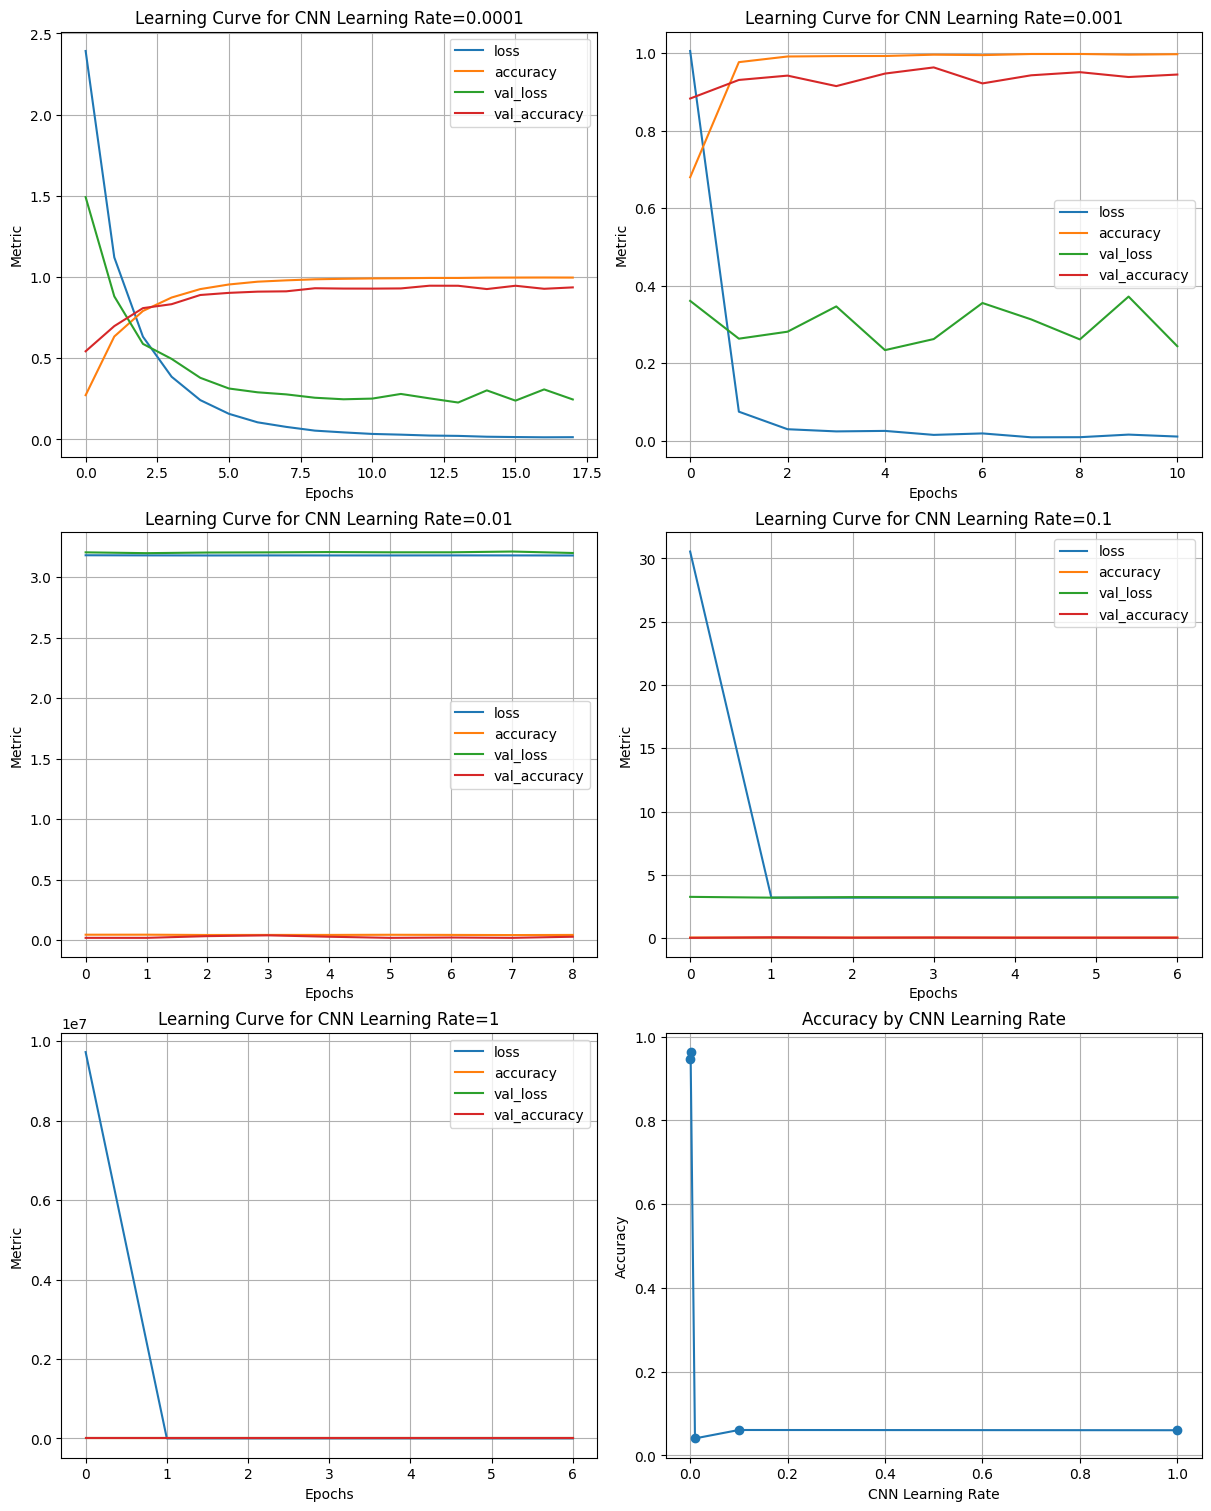

In [211]:
lr_setup = [1,0.1, 0.01,0.001,0.0001]

for i in lr_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = i
    model = model_cnn(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20,verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    cnn_lr_results[i] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(cnn_lr_results, "CNN Learning Rate")

#### The optimal number of layers for the CNN model:
- `64` is the optimal number of layers for the CNN model.
- Under `500,000` total parameters achieves the best performance in `Median Accuracy` with a value of `0.99`.
- It also has the best performance in `Maximum Validation Accuracy`, with a value over `0.965`.
- The total number of parameters is `471,384`, which fits the requirement of being under `500,000`.

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
CNN Number of Layers,,,,,
16,346920,0.980860,24 : 1.00,19 : 0.65,"{19: 0.65, 10: 0.76, 20: 0.81}"
32,388408,0.989830,24 : 1.00,13 : 0.86,"{13: 0.86, 19: 0.9, 12: 0.9}"
64,471384,0.994924,24 : 1.00,18 : 0.80,"{18: 0.8, 19: 0.86, 14: 0.89}"
128,637336,0.995146,18 : 1.00,8 : 0.83,"{8: 0.83, 12: 0.89, 6: 0.89}"
256,969240,0.990741,24 : 1.00,17 : 0.60,"{17: 0.6, 20: 0.78, 21: 0.86}"


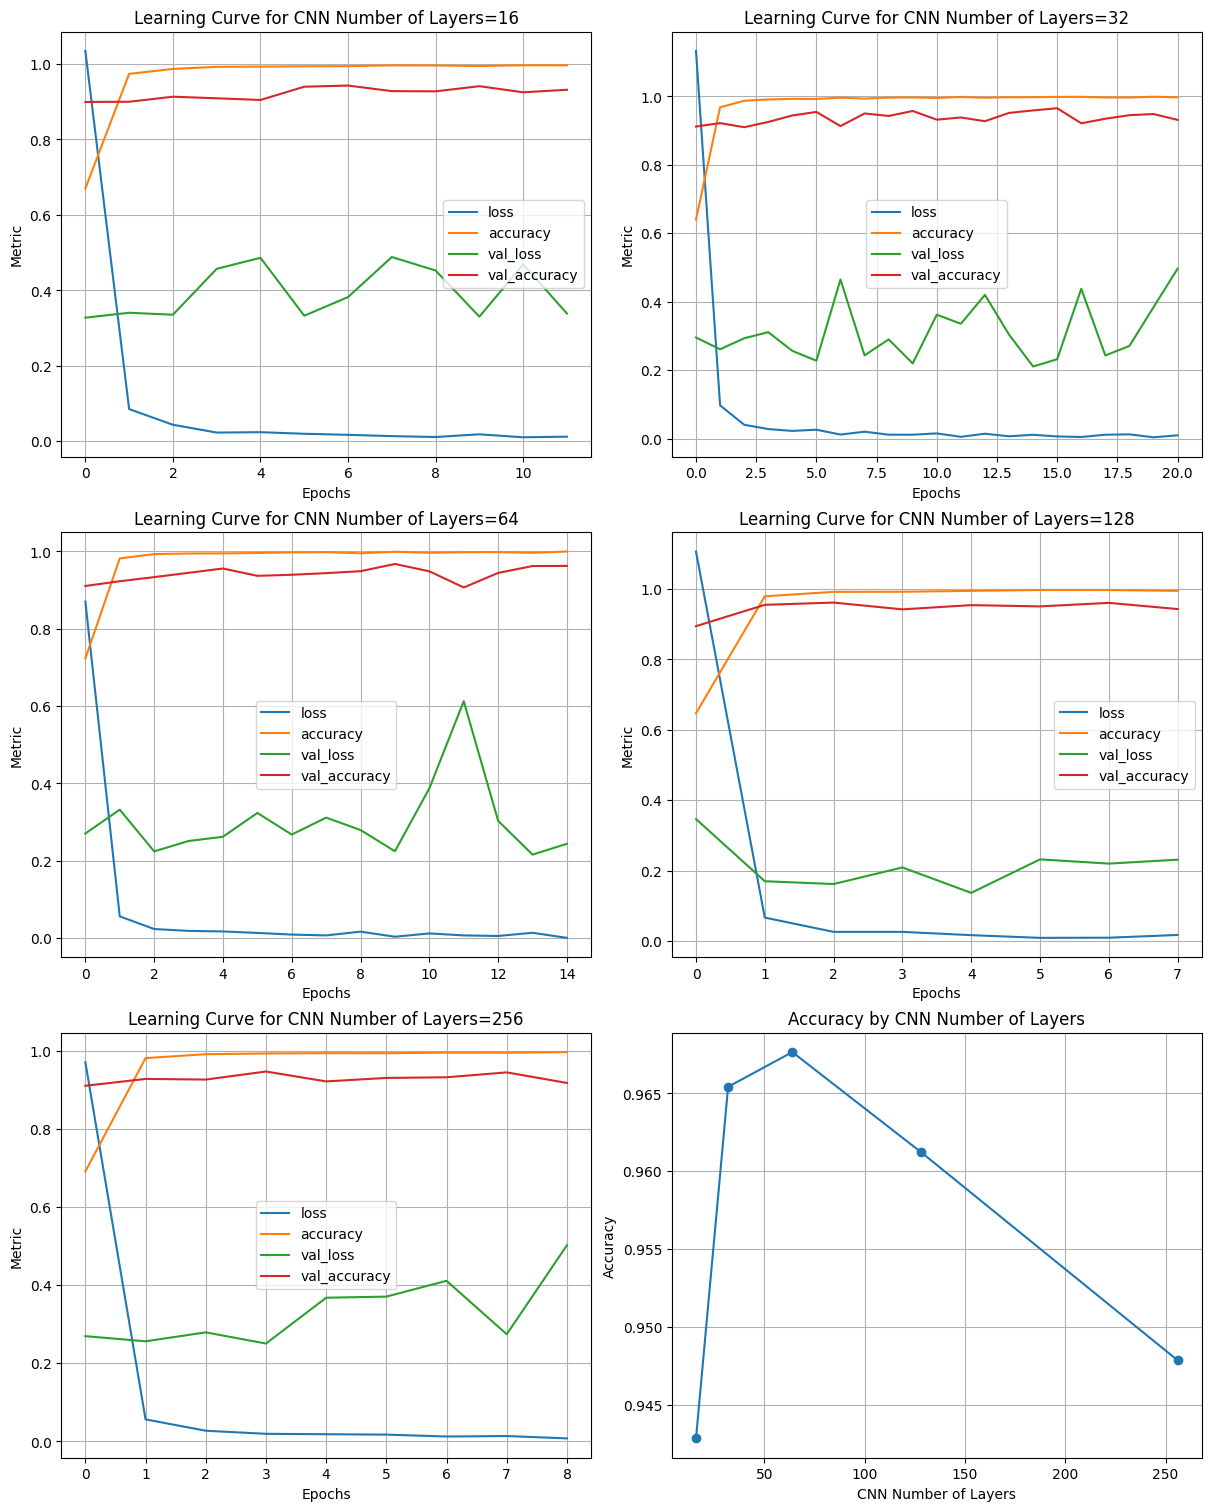

In [29]:
layers_setup = [16, 32, 64, 128, 256]

for i in layers_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32,i,256]
    model = model_cnn(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=50, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    cnn_layers_results[i] =  {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(cnn_layers_results, "CNN Number of Layers")

#### The best optimizer for CNN model:
- `Nadam` is the best optimizer for CNN model
- The best performance in `Median Accuracy` with `1.0`
- The best performance in `Highest Accuracy Letter` and `Lowest Accuracy Letter` with `1.00` and `0.73`
- The best performance in `Maxium validation accuracy` with near `1.0`

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
CNN Optimizer,,,,,
SGD,471384,0.000000,11 : 1.00,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"
Adam,471384,0.991870,16 : 1.00,19 : 0.70,"{19: 0.7, 6: 0.86, 10: 0.88}"
RMSprop,471384,0.981621,23 : 1.00,17 : 0.68,"{17: 0.68, 13: 0.83, 8: 0.84}"
Nadam,471384,1.000000,18 : 1.00,19 : 0.73,"{19: 0.73, 13: 0.89, 14: 0.91}"
Adadelta,471384,0.000000,21 : 0.64,5 : 0.00,"{0: 0.0, 1: 0.0, 2: 0.0}"


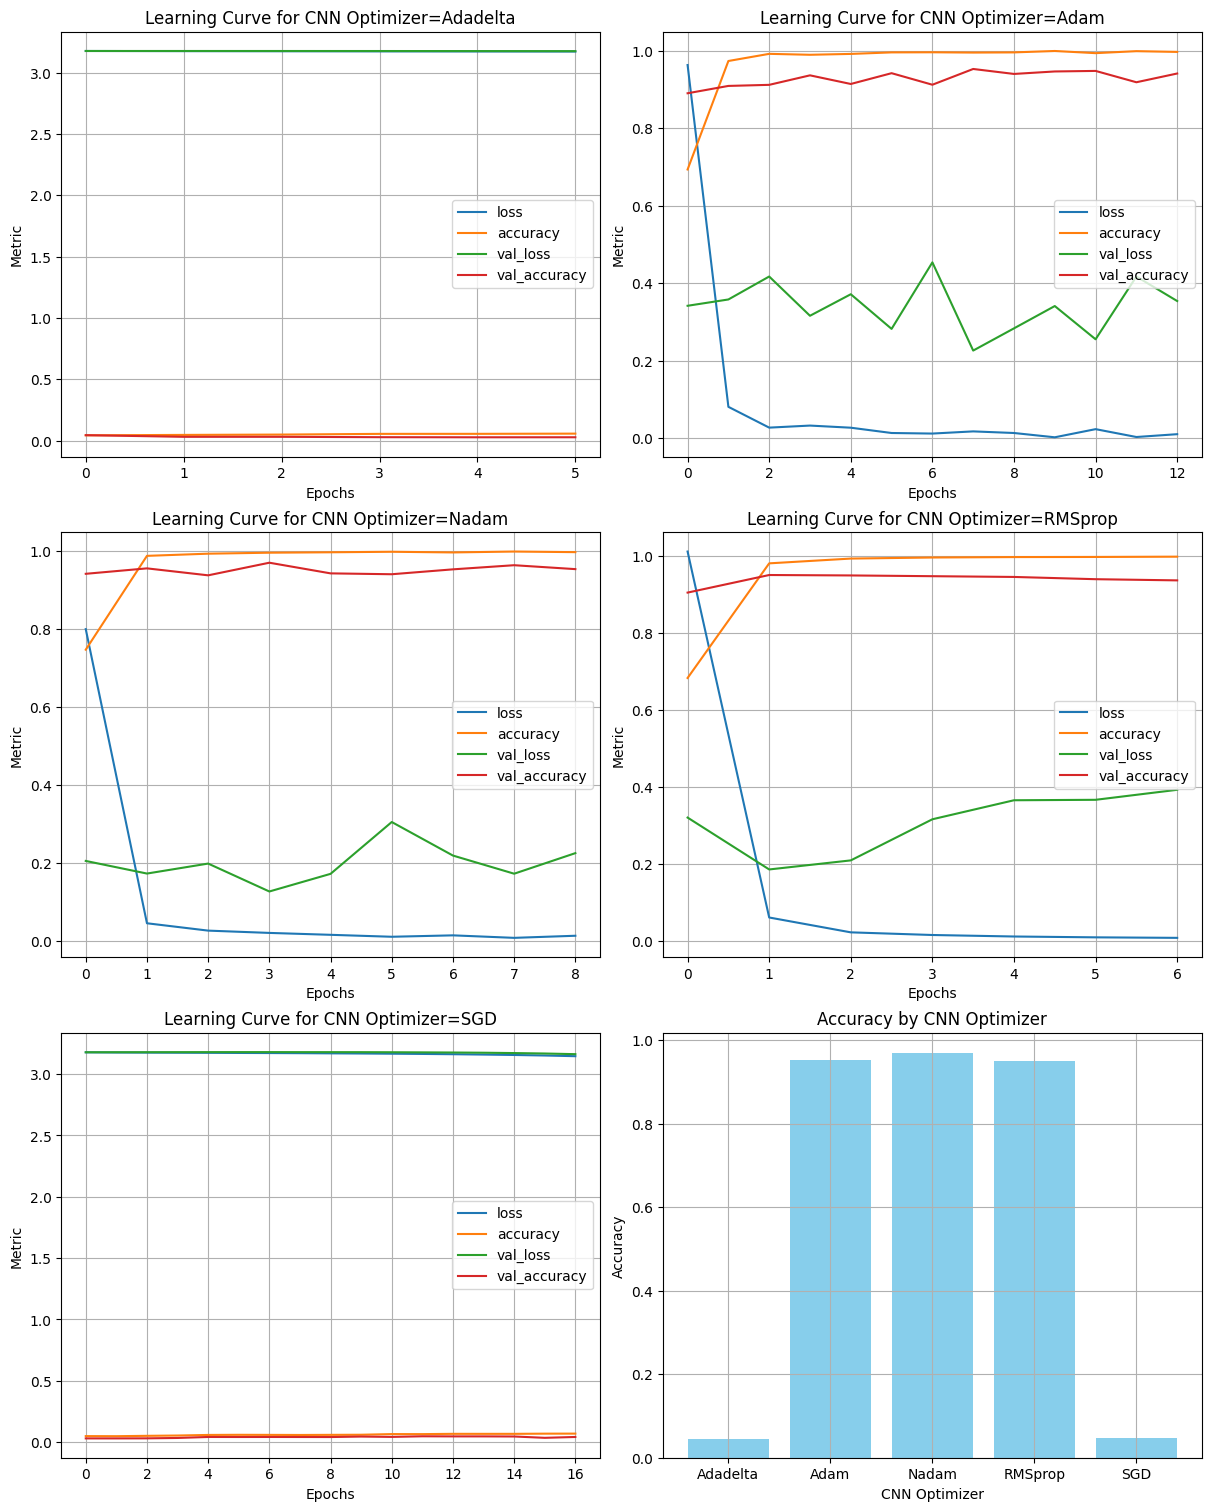

In [214]:
optimizer_setup = [keras.optimizers.legacy.SGD, keras.optimizers.legacy.Adam,keras.optimizers.legacy.RMSprop, keras.optimizers.legacy.Nadam, keras.optimizers.legacy.Adadelta]

for i in optimizer_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32,64,256]
    model_config_copy['optimizer'] = i
    model = model_cnn(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    cnn_optimizer_results[i.__name__] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(cnn_optimizer_results, "CNN Optimizer", type='bar')

#### The optimal activation function for the CNN Model:
- `relu` is the optimal activation function for the CNN model.
- It achieves similar performance in `Median Accuracy` compared to the most accurate activation function.
- The fluctuation of validation loss is steadier than the most accurate activation function.

,Total Parameter,Median Accuracy,Highest Accuracy Letter: Accuracy,Lowest Accuracy Letter: Accuracy,Top 3 Errors
CNN activation function,,,,,
relu,471384,0.989583,24 : 1.00,19 : 0.82,"{19: 0.82, 18: 0.89, 20: 0.89}"
elu,471384,0.987867,18 : 1.00,19 : 0.65,"{19: 0.65, 17: 0.85, 12: 0.88}"
leaky_relu,471384,1.000000,18 : 1.00,17 : 0.83,"{17: 0.83, 10: 0.89, 24: 0.89}"
selu,471384,0.959309,16 : 1.00,10 : 0.79,"{10: 0.79, 19: 0.82, 17: 0.83}"
tanh,471384,1.000000,18 : 1.00,19 : 0.65,"{19: 0.65, 24: 0.89, 20: 0.92}"


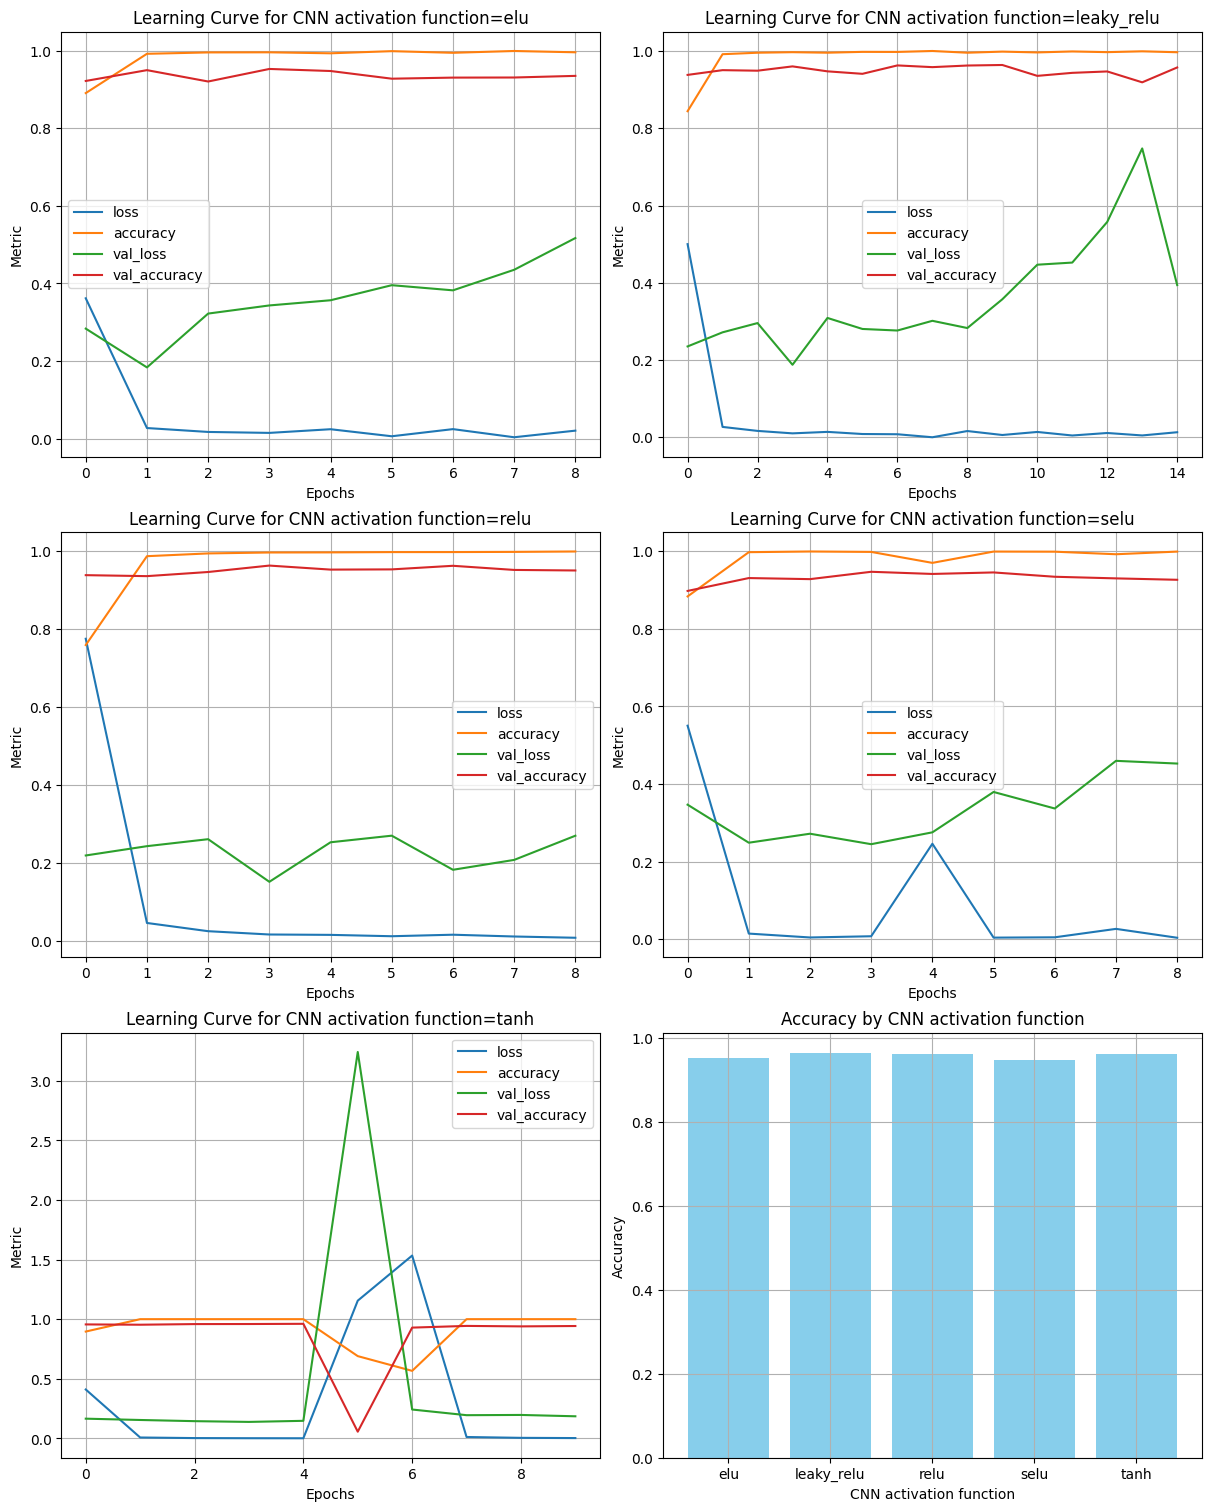

In [216]:
activation_function_setup = ["relu", "elu", "leaky_relu", "selu", "tanh"]

for i in activation_function_setup:
    model_config_copy = baseline_model_config.copy()
    model_config_copy['learning_rate'] = 0.001
    model_config_copy['hidden_sizes'] = [32, 64, 256]
    model_config_copy['optimizer'] = keras.optimizers.legacy.Nadam
    model_config_copy['activation_function'] = i
    model = model_cnn(model_config_copy)
    max_val_acc, history, model = train_model(model, n_epochs=20, verbose=0)
    model_result = calculate_letter_accuracies(model, X_val, y_val)
    cnn_activation_function_result[i] = {"history" : history,"accuracy" : max_val_acc, "result": model_result, "total_parameters": model.count_params()}

plot_results(cnn_activation_function_result, "CNN activation function", type='bar')

#### The summary of the optimal Hyper-parameter for CNN model:
| Parameter               | Value                                 |
|-------------------------|---------------------------------------|
| **Hidden Sizes**         | [32, 64, 256]  |
| **Activation Function**  | `relu`                                |
| **Optimizer**            | `keras.optimizers.legacy.Nadam`       |
| **Learning Rate**        | 0.001                                 |

## 3. Comparison of models, selection of the best model

### 3.1 The Best Dense Model

In [12]:
best_dense_config = {
    'hidden_sizes': [32, 128, 256], 
    'activation_function': "elu",
    'optimizer': keras.optimizers.legacy.Nadam,              
    'learning_rate': 0.001
}

best_dense_model = model_dense(best_dense_config)

best_dense_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                32800     
                                                                 
 dense_5 (Dense)             (None, 128)               4224      
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 24)                6168      
                                                                 
Total params: 76216 (297.72 KB)
Trainable params: 76216 (297.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


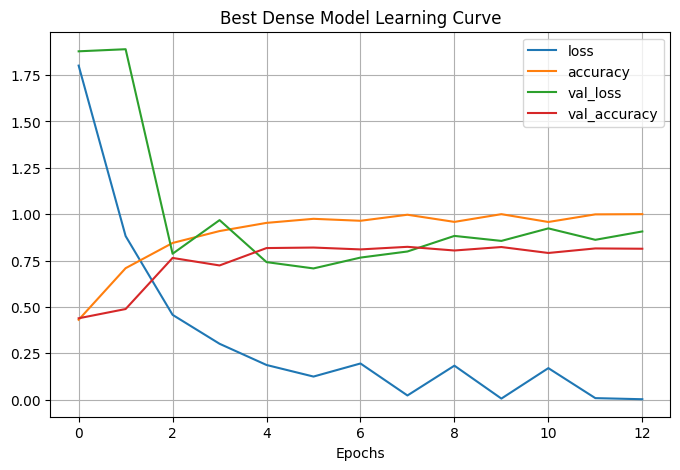

In [18]:
best_dense_model_max_val_acc, best_dense_model_history, best_dense_model = train_model(best_dense_model, verbose=0)
plot_learning_curves(best_dense_model_history, "Best Dense Model")

In [19]:
best_dense_result = calculate_letter_accuracies(best_dense_model, X_val, y_val)
interpret_result(best_dense_result)

Mean Accuracy: 0.82
Median Accuracy: 0.80

Highest Accuracy Letter: Q with 1.00 accuracy
Lowest Accuracy Letter: S with 0.50 accuracy

Top 3 Labels with Lowest Accuracies:
Accuracy for letter S: 0.50
Accuracy for letter K: 0.53
Accuracy for letter W: 0.59

Individual Accuracies:
Accuracy for letter A: 1.00
Accuracy for letter B: 0.99
Accuracy for letter C: 1.00
Accuracy for letter D: 0.88
Accuracy for letter E: 0.96
Accuracy for letter F: 0.96
Accuracy for letter G: 0.80
Accuracy for letter H: 0.87
Accuracy for letter I: 0.80
Accuracy for letter K: 0.53
Accuracy for letter L: 0.99
Accuracy for letter M: 0.71
Accuracy for letter N: 0.76
Accuracy for letter O: 0.80
Accuracy for letter P: 1.00
Accuracy for letter Q: 1.00
Accuracy for letter R: 0.75
Accuracy for letter S: 0.50
Accuracy for letter T: 0.61
Accuracy for letter U: 0.76
Accuracy for letter V: 0.65
Accuracy for letter W: 0.59
Accuracy for letter X: 0.92
Accuracy for letter Y: 0.77


### 3.2 The Best CNN Model

In [15]:
best_cnn_config = {
    'hidden_sizes': [32, 64, 256],  
    'activation_function': "relu",
    'optimizer': keras.optimizers.legacy.Nadam,              
    'learning_rate': 0.001
}

best_cnn_model = model_cnn(best_cnn_config)

best_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 256)         147712    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 256)        

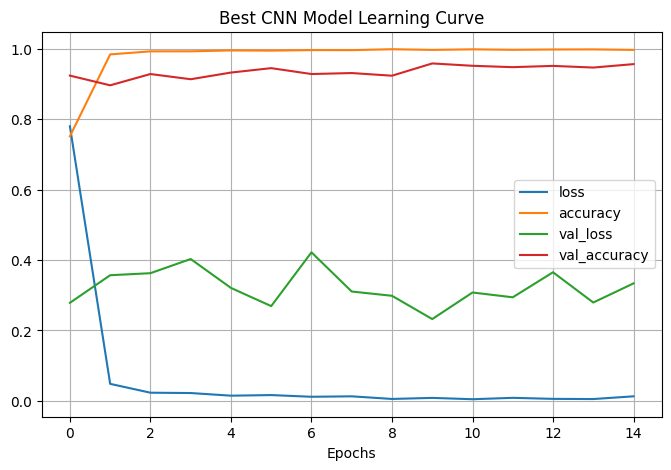

In [16]:
best_cnn_model_max_val_acc, best_cnn_model_history, best_cnn_model = train_model(best_cnn_model,verbose=0)
plot_learning_curves(best_cnn_model_history, "Best CNN Model")

In [219]:
best_cnn_result = calculate_letter_accuracies(best_cnn_model, X_val, y_val)
interpret_result(best_cnn_result)

Mean Accuracy: 0.96
Median Accuracy: 0.97

Highest Accuracy Letter: S with 1.00 accuracy
Lowest Accuracy Letter: R with 0.83 accuracy

Top 3 Labels with Lowest Accuracies:
Accuracy for letter R: 0.83
Accuracy for letter Y: 0.89
Accuracy for letter B: 0.89

Individual Accuracies:
Accuracy for letter A: 1.00
Accuracy for letter B: 0.89
Accuracy for letter C: 1.00
Accuracy for letter D: 0.90
Accuracy for letter E: 0.98
Accuracy for letter F: 1.00
Accuracy for letter G: 0.91
Accuracy for letter H: 0.94
Accuracy for letter I: 0.90
Accuracy for letter K: 0.93
Accuracy for letter L: 1.00
Accuracy for letter M: 1.00
Accuracy for letter N: 0.94
Accuracy for letter O: 0.98
Accuracy for letter P: 1.00
Accuracy for letter Q: 1.00
Accuracy for letter R: 0.83
Accuracy for letter S: 1.00
Accuracy for letter T: 0.95
Accuracy for letter U: 0.98
Accuracy for letter V: 0.95
Accuracy for letter W: 1.00
Accuracy for letter X: 0.93
Accuracy for letter Y: 0.89


#### 3.3 Summary of Model Performance:

| Metric                                   | dense_baseline_model | best_dense_model | best_cnn_model |
|------------------------------------------|----------------------|----------------------------|--------------------------|
| **Total Parameters**                     | 48,472               | 76,216                        | 471,384                  |
| **Mean Accuracy**                        | 0.61                 | 0.82                       | 0.96                     |
| **Median Accuracy**                      | 0.63                 | 0.80                       | 0.97                     |
| **Highest Accuracy Letter**              | A (0.95)             | Q (1.00)                   | S (1.00)                 |
| **Lowest Accuracy Letter**               | R (0.07)             | S (0.50)                   | R (0.83)                 |
| **Top 3 Labels with Lowest Accuracies**  |                      |                            |                          |
|                                          | R (0.07)             | S (0.50)                   | R (0.83)                 |
|                                          | N (0.23)             | K (0.53)                   | Y (0.89)                 |
|                                          | K (0.25)             | W (0.59)                   | B (0.89)                 |
| **Individual Accuracies**                |                      |                            |                          |
| Accuracy for letter A                    | 0.95                 | 1.00                       | 1.00                     |
| Accuracy for letter B                    | 0.90                 | 0.99                       | 0.89                     |
| Accuracy for letter C                    | 0.92                 | 1.00                       | 1.00                     |
| Accuracy for letter D                    | 0.39                 | 0.88                       | 0.90                     |
| Accuracy for letter E                    | 0.87                 | 0.96                       | 0.98                     |
| Accuracy for letter F                    | 0.70                 | 0.96                       | 1.00                     |
| Accuracy for letter G                    | 0.64                 | 0.80                       | 0.91                     |
| Accuracy for letter H                    | 0.82                 | 0.87                       | 0.94                     |
| Accuracy for letter I                    | 0.59                 | 0.80                       | 0.90                     |
| Accuracy for letter K                    | 0.25                 | 0.53                       | 0.93                     |
| Accuracy for letter L                    | 0.65                 | 0.99                       | 1.00                     |
| Accuracy for letter M                    | 0.57                 | 0.71                       | 1.00                     |
| Accuracy for letter N                    | 0.23                 | 0.76                       | 0.94                     |
| Accuracy for letter O                    | 0.59                 | 0.80                       | 0.98                     |
| Accuracy for letter P                    | 0.78                 | 1.00                       | 1.00                     |
| Accuracy for letter Q                    | 0.48                 | 1.00                       | 1.00                     |
| Accuracy for letter R                    | 0.07                 | 0.75                       | 0.83                     |
| Accuracy for letter S                    | 0.43                 | 0.50                       | 1.00                     |
| Accuracy for letter T                    | 0.45                 | 0.61                       | 0.95                     |
| Accuracy for letter U                    | 0.70                 | 0.76                       | 0.98                     |
| Accuracy for letter V                    | 0.61                 | 0.65                       | 0.95                     |
| Accuracy for letter W                    | 0.73                 | 0.59                       | 1.00                     |
| Accuracy for letter X                    | 0.74                 | 0.92                       | 0.93                     |
| Accuracy for letter Y                    | 0.60                 | 0.77                       | 0.89                     |


#### Model selection:
- The `best_cnn_model` is the best model
- It has the best performance in the validation data set, including `Mean Accuracy`, `Median Accuracy` and overall accuracy for all individual letter. 
- The model has 471,384 total parameter, which is within the 500,000 limit. 

### 3.4 Final performance testing

In [220]:
final_cnn_result = calculate_letter_accuracies(best_cnn_model, X_test, y_test)
interpret_result(final_cnn_result)

Mean Accuracy: 0.95
Median Accuracy: 0.97

Highest Accuracy Letter: F with 1.00 accuracy
Lowest Accuracy Letter: N with 0.86 accuracy

Top 3 Labels with Lowest Accuracies:
Accuracy for letter N: 0.86
Accuracy for letter Y: 0.87
Accuracy for letter R: 0.88

Individual Accuracies:
Accuracy for letter A: 1.00
Accuracy for letter B: 0.90
Accuracy for letter C: 1.00
Accuracy for letter D: 0.94
Accuracy for letter E: 0.98
Accuracy for letter F: 1.00
Accuracy for letter G: 0.88
Accuracy for letter H: 0.96
Accuracy for letter I: 0.95
Accuracy for letter K: 0.92
Accuracy for letter L: 1.00
Accuracy for letter M: 1.00
Accuracy for letter N: 0.86
Accuracy for letter O: 0.98
Accuracy for letter P: 1.00
Accuracy for letter Q: 1.00
Accuracy for letter R: 0.88
Accuracy for letter S: 1.00
Accuracy for letter T: 0.92
Accuracy for letter U: 0.99
Accuracy for letter V: 0.97
Accuracy for letter W: 1.00
Accuracy for letter X: 0.91
Accuracy for letter Y: 0.87


#### The result of final testing:

| Metric                                   | New Model |
|------------------------------------------|-----------|
| **Mean Accuracy**                        | 0.95      |
| **Median Accuracy**                      | 0.97      |
| **Highest Accuracy Letter**              | F (1.00)  |
| **Lowest Accuracy Letter**               | N (0.86)  |
| **Top 3 Labels with Lowest Accuracies**  |           |
|                                          | N (0.86)  |
|                                          | Y (0.87)  |
|                                          | R (0.88)  |
| **Individual Accuracies**                |           |
| Accuracy for letter A                    | 1.00      |
| Accuracy for letter B                    | 0.90      |
| Accuracy for letter C                    | 1.00      |
| Accuracy for letter D                    | 0.94      |
| Accuracy for letter E                    | 0.98      |
| Accuracy for letter F                    | 1.00      |
| Accuracy for letter G                    | 0.88      |
| Accuracy for letter H                    | 0.96      |
| Accuracy for letter I                    | 0.95      |
| Accuracy for letter K                    | 0.92      |
| Accuracy for letter L                    | 1.00      |
| Accuracy for letter M                    | 1.00      |
| Accuracy for letter N                    | 0.86      |
| Accuracy for letter O                    | 0.98      |
| Accuracy for letter P                    | 1.00      |
| Accuracy for letter Q                    | 1.00      |
| Accuracy for letter R                    | 0.88      |
| Accuracy for letter S                    | 1.00      |
| Accuracy for letter T                    | 0.92      |
| Accuracy for letter U                    | 0.99      |
| Accuracy for letter V                    | 0.97      |
| Accuracy for letter W                    | 1.00      |
| Accuracy for letter X                    | 0.91      |
| Accuracy for letter Y                    | 0.87      |


### 3.5 Recommendation:

The model has fully achieved the performance goal, with a median accuracy exceeding 94%, and every individual letter having an accuracy above 85%. The best model's results show a 97% median accuracy, with the lowest accuracy letter at 86%, meaning every individual letter meets the requirement of being above 85% accuracy. On the other hand, the total parameters of the best model are 471,384, which is within the limit of 500,000 total parameters. To further improve overall performance, adding additional augmentation in the `ImageDataGenerator` step could enhance the model's performance. 
